# Temperature Salinity Plots

In this notebook there are a few examples on how to plot temperature-salinity diagrams of model output. The cosima cookbook is used to extract data, however there are other methods including using dask to get variables that could also be used, that are contained (but are outdated) in previous versions of this notebook.

The first method uses pandas dataframe to plot the data, and then pandas dataframe to add a colourmap from the age variable. 

The second method uses xarray scatter plots to plot the data, with the colourmap aso available.

The third method uses meshgrid to plot a T-S diagram without pandas, instead with the xarray DataArray object. Its limitation is that it is low. 

The fourth method uses the DataArray to make a 2D scipy histogram so that a volume weighted T-S plot can be constructed. The density isopycnals are also included in here too because they are often useful for these types of plots.

In [1]:
import dask
import dask.array as da
import dask.dataframe as dd
from dask import delayed
import numpy as np
import xarray as xr
from distributed.diagnostics.progressbar import progress
import cosima_cookbook as cc
import bokeh.plotting as bp
#from datashader.bokeh_ext import InteractiveImagevdoes (didn't work with conda enc:analysis3-20.01)

import matplotlib.pyplot as plt
import pandas as pd

import datashader as ds
import datashader.transfer_functions as tf
import gsw
import scipy as scipy
from scipy import stats


In [2]:
from dask.distributed import Client

print('starting distributed client...')
client = Client()
display(client)

starting distributed client...


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:44774 Dashboard: http://127.0.0.1:34004/status,Cluster Workers: 4 Cores: 8 Memory: 33.67 GB


The normal cosima cookbook loading variables...

In [2]:
session = cc.database.create_session()

In [12]:
expt = '01deg_jra55v13_ryf9091'

In [13]:
temp = cc.querying.getvar(expt, 'temp', session, 'ocean.nc', 
                          start_time='2059-01-01', end_time = '2060-01-01', n=1).sel(xt_ocean=slice(-195,-175)).sel(yt_ocean=slice(-78,-68))
salt = cc.querying.getvar(expt, 'salt', session, 'ocean.nc', 
                          start_time='2000-01-01', end_time = '2060-01-01', n=1).sel(xt_ocean=slice(-195,-175)).sel(yt_ocean=slice(-78,-68))


## Plotting T-S diagrams with pandas and dask dataframe

Constructing the dataframe in pandas

In [16]:
t_blocks = [x.reshape((-1,)) for x in temp.data.to_delayed().reshape((-1,))]
s_blocks = [x.reshape((-1,)) for x in salt.data.to_delayed().reshape((-1,))]
dfs = [delayed(pd.DataFrame)({'temp': t, 'salt': s}, copy=False) for t, s in zip(t_blocks, s_blocks)]

Using dask.dataframe 

In [17]:
df = dd.from_delayed(dfs)

Plotting the image.

In [18]:
cvs = ds.Canvas(plot_width=400, plot_height=400)
agg = cvs.points(df, 'salt', 'temp')
img = tf.shade(agg, cmap=['lightblue', 'darkblue'], how='log')

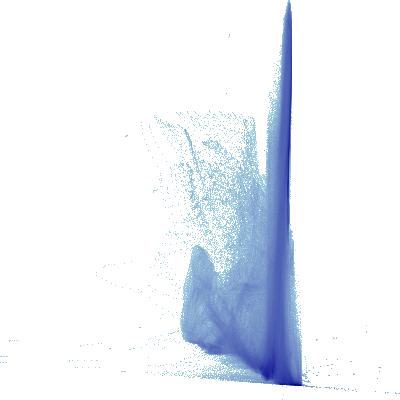

In [19]:
display(img)

In [20]:
##### Below is the code to make an animated picture using Bokeh Plot. Works with older versions of kernel but not conda env:analysis3-20.01



# Default plot ranges: 
#y_range = (-2, 32) # temperature
#x_range = (10, 40) # salinity

In [21]:
#def create_image(x_range=x_range, y_range=y_range, w=500, h=500):
#    cvs = ds.Canvas(x_range=x_range, y_range=y_range, plot_height=h, plot_width=w)
#    agg = cvs.points(df, 'salt', 'temp')
#    return tf.shade(agg, cmap=plt.cm.viridis_r)

In [10]:
#bp.output_notebook()
#
#def base_plot(tools='pan,wheel_zoom,box_zoom,reset'):
#    p = bp.figure(tools=tools, plot_width=500, plot_height=500,
#        x_range=x_range, y_range=y_range, outline_line_color=None,
#        min_border=0, min_border_left=0, min_border_right=0,
#        min_border_top=0, min_border_bottom=0)   
#    p.xgrid.grid_line_color = None
#    p.ygrid.grid_line_color = None
#    p.xaxis.axis_label = 'Practical Salinity'
#    p.yaxis.axis_label = 'Potential Temperature'
#    return p
#
#p = base_plot()
#InteractiveImage(p, create_image)

## Forming a pandas dataframe and plotting with a third variable

In [12]:
temp = cc.querying.getvar(expt, 'temp', session, 'ocean.nc', 
                          start_time='2059-01-01', end_time = '2060-01-01', n=1).sel(xt_ocean=slice(-195,-175)).sel(yt_ocean=slice(-78,-68))
salt = cc.querying.getvar(expt, 'salt', session, 'ocean.nc', 
                          start_time='2000-01-01', end_time = '2060-01-01', n=1).sel(xt_ocean=slice(-195,-175)).sel(yt_ocean=slice(-78,-68))
age_global = cc.querying.getvar(expt, 'age_global', session, 'ocean.nc', 
                          start_time='2000-01-01', end_time = '2060-01-01', n=1).sel(xt_ocean=slice(-195,-175)).sel(yt_ocean=slice(-78,-68))


In [13]:
temp2 = temp.values.reshape(1,-1)[0]-273.15
salt2 = salt.values.reshape(1,-1)[0]
age_global2 = age_global.values.reshape(1,-1)[0]

In [14]:
%%time
df = pd.DataFrame({'temp': temp2, 'salt' : salt2, 'age_global' : age_global2}, copy=False)

CPU times: user 26 ms, sys: 84 ms, total: 110 ms
Wall time: 104 ms


Above we repeated the pandas construction of a DataFrame as performed earlier, but with a third variable age_global that will colour the datapoints in the T-S plot.

In [15]:
# Default plot ranges:
y_range = (-2, 5) # temperature
x_range = (32, 36) # salinity

In [16]:
def create_image(x_range=x_range, y_range=y_range, w=500, h=500):
    cvs = ds.Canvas(x_range=x_range, y_range=y_range, plot_height=h, plot_width=w)
    agg = cvs.points(df, 'salt', 'temp', ds.mean('age_global'))
    return tf.shade(agg)

In [17]:
%%time
cvs = ds.Canvas(plot_width=500, plot_height=500,x_range=x_range, y_range=y_range)
agg = cvs.points(df, 'salt', 'temp')

CPU times: user 634 ms, sys: 66 ms, total: 700 ms
Wall time: 688 ms


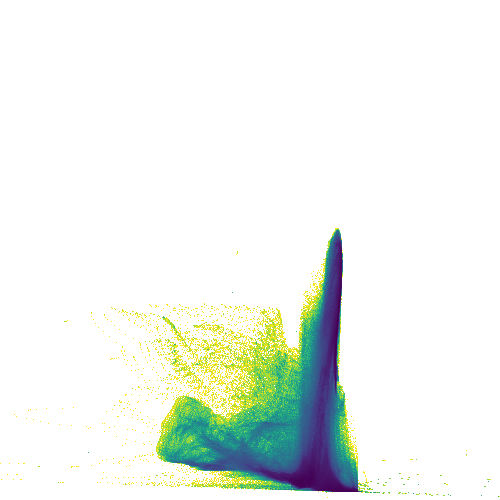

In [18]:
img = tf.shade(agg, cmap=plt.cm.viridis_r)
img

In [11]:
#Another interactive plot that does not currently work
#bp.output_notebook()

#def base_plot(tools='pan,wheel_zoom,box_zoom,reset'):
#    p = bp.figure(tools=tools, plot_width=500, plot_height=500,
#        x_range=x_range, y_range=y_range, outline_line_color=None,
#        min_border=0, min_border_left=0, min_border_right=0,
#        min_border_top=0, min_border_bottom=0)   
#    p.xgrid.grid_line_color = None
#   p.ygrid.grid_line_color = None
#   p.xaxis.axis_label = 'Practical Salinity'
#   p.yaxis.axis_label = 'Potential Temperature'
#    return p

#p = base_plot()
#InteractiveImage(p, create_image)

## Xr scatter plot method
Here we load the variables and combine them into a dataarray. I have uploaded the bathymetry and area of grid cells because they are used in the 2D histogram in the next method.

Notice that the start_time and end_time varies between variables, because cosima cookbook is inconsistent in which times it extracts with the start_time and end_time. Double check your data by printing the arrays and seeing which times got extracted, and adjust as necessary to make sure all the arrays have the same start and end dates in the extracted data.

In [3]:
expt = '01deg_jra55v13_ryf9091'
variable = 'salt'
darray = cc.querying.getvar(expt,variable, session,ncfile='ocean.nc', start_time='2059-02-01', end_time='2059-12-31', chunks={'st_ocean':None})
variable1 = 'temp'
darray1 = cc.querying.getvar(expt,variable1, session,ncfile='ocean.nc', start_time='2059-02-01', end_time='2059-12-31', chunks={'st_ocean':None})
variable2 = 'pot_rho_2'
darray2 = cc.querying.getvar(expt,variable2, session,ncfile='ocean.nc', start_time='2059-03-01', end_time='2059-12-31', chunks={'st_ocean':None})
variable3 = 'age_global'
darray3 = cc.querying.getvar(expt,variable3, session,ncfile='ocean.nc', start_time='2059-02-01', end_time='2059-12-31', chunks={'st_ocean':None})
variable4= 'dzt' #depth of cell, varies in time 
darray4 = cc.querying.getvar(expt,variable4, session,ncfile='ocean.nc', start_time='2059-02-01', end_time='2059-12-31', chunks={'st_ocean':None})
variable5= 'area_t' #area of a cell
darray5 = cc.querying.getvar(expt,variable5, session,n=1)
variable6= 'ht' #bathymetry
darray6 = cc.querying.getvar(expt,variable6, session,n=1)

combined_array = xr.merge([darray, darray1, darray2, darray3, darray4, darray5, darray6])

combined_array has the data for the whole ocean so I crop out a region, in this case in the Ross Sea

In [4]:
section = combined_array.sel(xt_ocean=slice(-195,-175)).sel(yt_ocean=slice(-78,-68))

Now use xr.plot.scatter to make T-S diagram, with the age_global variable as a colour.

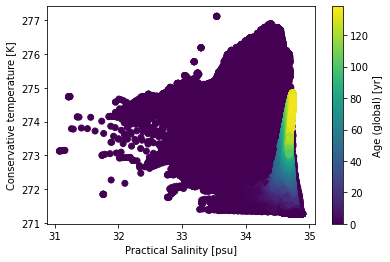

In [5]:
xr.plot.scatter(section.isel(time=0), 'salt', 'temp', hue='age_global')

## Volume weighted T-S diagram

Here is a T-S diagram where the colour of a pixel is determined by the volume of the cell. This helps account for varying sizes of cells and also allows you to calculate volumes of regions in T-S diagrams, for example to calculate the volume of a watermass with T-S characteristics.
There is also a method of calculating the freezing point and isopycnals which uses the Gibbs SeaWater (GSW) Oceanographic Toolbox. When I do this I change my x axis to absolute rather than practical salinity.

First I add some variables of volume and the x,y,z coordinates as variables to the dataArray, because the dataArray had issues being input into scipy when x,y,z were coordinates rather than variables.

In [6]:
section = section.assign(volume = lambda section : section.dzt * section.area_t)
section = section.assign(x = lambda section : section.salt*0+section.xt_ocean)
section = section.assign(y = lambda section : section.salt*0+section.yt_ocean)
section = section.assign(z = lambda section : section.salt*0+section.st_ocean)

Now I define the pressure and absolute salinity as dataArrays.

In [7]:
trough = section

da_pressure = xr.DataArray(gsw.p_from_z(-trough.z, trough.y), dims=['time', 'st_ocean','yt_ocean','xt_ocean'],
                           coords={'time': trough.time,
                                   'st_ocean': trough.st_ocean,
                                   'yt_ocean': trough.yt_ocean,
                                   'xt_ocean': trough.xt_ocean})

da_saltabs = xr.DataArray(gsw.SA_from_SP(trough.salt, da_pressure, trough.x, trough.y), dims=['time', 'st_ocean','yt_ocean','xt_ocean'],
                           coords={'time': trough.time,
                                   'st_ocean': trough.st_ocean,
                                   'yt_ocean': trough.yt_ocean,
                                   'xt_ocean': trough.xt_ocean})

We reshape the dataArrays into lists, noting that due to the same shape of these arrays (see above note about start_time and end_time checking) the nth member of the list will correspond to the nth member of another list.

In [8]:
x = trough.isel(time= 0).temp.values.reshape(1,-1)
x = x[~np.isnan(x)] -273.15 #list of conservative temperatures of data points in degC

y = trough.isel(time= 0).volume.values.reshape(1,-1)
y = y[~np.isnan(y)]

z = da_saltabs.isel(time=0).values.reshape(1,-1)
z = z[~np.isnan(z)]

Here use stat.binned_statistic_2d to bin the T-S data into bins. There are some extra parameters you can feed it but here we just set the number of bins in each axis to be 100, which will evenly space the bin edges from the minimum and maximum values of the data. We use bin statistic sum to add up the volume in each T-S bin.
Then by constructing a meshgrid and plotting the mesh, coloured by the value in the bin we output a 2D histogram. The isopycnals and freezing line are also added.

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: The following kwargs were not used by contour: 'interpolation'
  from ipykernel import kernelapp as app


Text(0, 0.5, 'Conservative Temperature (degrees C)')

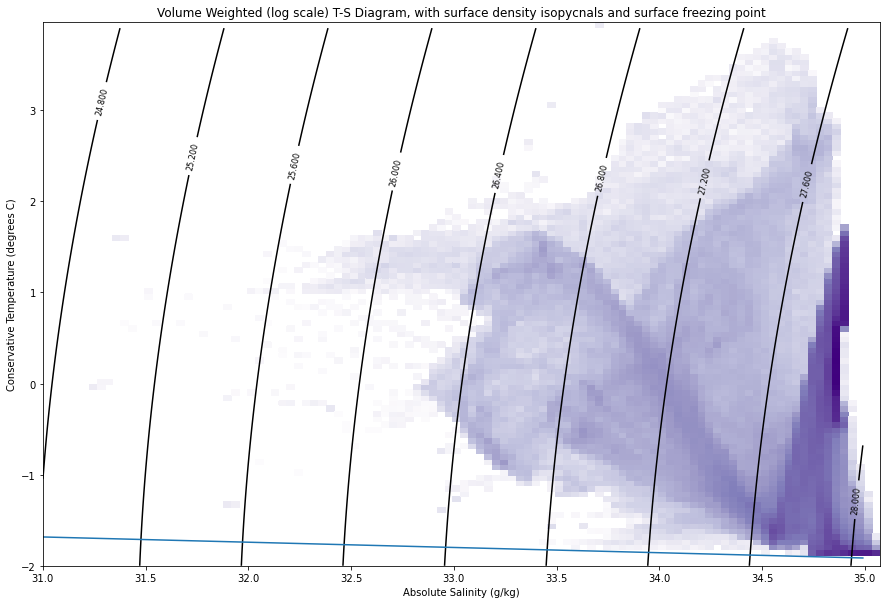

In [9]:
values, x_edges, y_edges, binnumber = stats.binned_statistic_2d(z, x, y, statistic = 'sum', bins = [100,100]) #increase resolution by increasing number of bins
XX, YY = np.meshgrid(y_edges,x_edges)

plt.figure(figsize=(15,10))
plt.title('Volume Weighted (log scale) T-S Diagram, with surface density isopycnals and surface freezing point')

plt.pcolormesh(YY,XX,np.log(values),cmap='Purples') #log is used because in this data at least, a large amount of 
                                                    #volume is concentrated in a couple of T-S bins so we can't see the rest.

temp = np.arange(-2,4,.1) #creating arrays for plotting the isopycnal and freezing point contours
salt = np.arange(31,35,.01)
plt.plot(salt, gsw.CT_freezing(salt,10.1325,0)) #freezing point contour, pressure = 10.1325 dbar and saturation_fraction=0 - you can modify the 
temp_mesh,salt_mesh = np.meshgrid(temp,salt)
density = gsw.density.sigma0(salt_mesh,temp_mesh) #I am using surface density pot_rho_0
contours = plt.contour(salt_mesh, temp_mesh, density, 10, colors='k',interpolation='none')
plt.clabel(contours, inline=True, fontsize=8)

plt.xlabel('Absolute Salinity (g/kg)')
plt.ylabel('Conservative Temperature (degrees C)')